<a href="https://colab.research.google.com/github/farhan1503001/Deep-Learning-Rhyme-Projects/blob/main/Aerial_Satellite_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

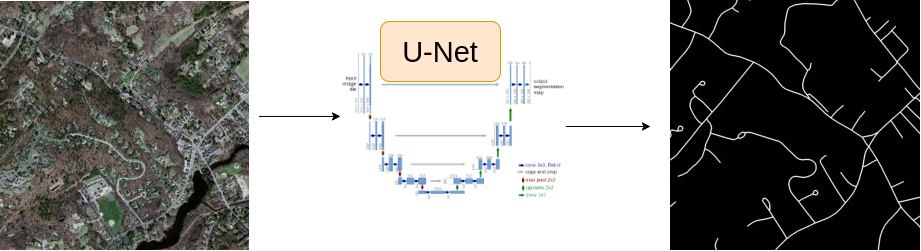

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [12]:
#Setting the system path 
import sys
sys.path.append('/content/Road_seg_dataset')

In [13]:
#Importing the necessary libraries
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [14]:
CSV_FILE='/content/Road_seg_dataset/train.csv'
DATA_DIR='/content/Road_seg_dataset/'

LR=0.003
BATCH_SIZE=8
IMG_SIZE=512

DEVICE='cuda'
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'



**Reading the csv file**

In [15]:
df=pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [16]:
idx=2

img_path=DATA_DIR+df.iloc[idx].images
mask_path=DATA_DIR+df.iloc[idx].masks

#Reading image and mask
image=cv2.imread(img_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

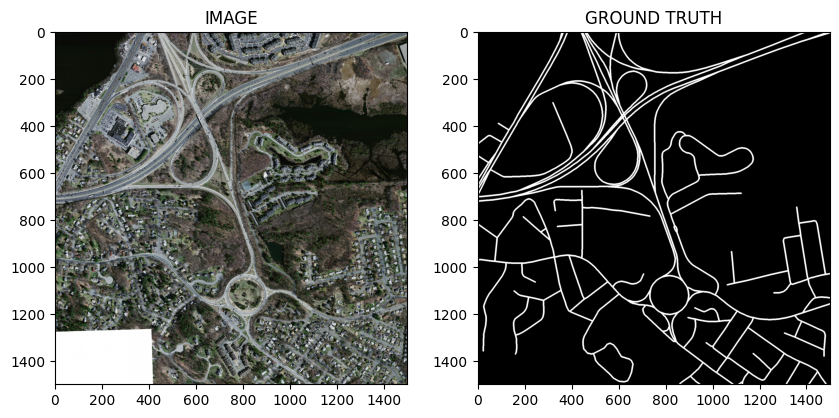

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

**Splitting dataset into train and test set**

In [23]:
train_df,valid_df=train_test_split(df,test_size=0.20,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [24]:
#At first we are importing the albumentation library for our cause
import albumentations as A

In [25]:
train_augs=A.Compose(
    [
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ]
)

valid_augs=A.Compose(
    [
        A.Resize(IMG_SIZE,IMG_SIZE)
    ]
)

# Task 4 : Create Custom Dataset 

In [26]:
from torch.utils.data import Dataset

In [27]:
class AerialImageDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations
  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]

    image_path=DATA_DIR+row.images
    mask_path=DATA_DIR+row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1) #(h,w,c)->(1,h,w,c)

    #Reading complete now perform augmentations
    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

    #Converting them from (h,w,c) to (c,h,w) format
    image=np.transpose(image,axes=(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,axes=(2,0,1)).astype(np.float32)

    #Converting it to tensor
    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)


    return image,mask

In [29]:
#Now creating train and valid set
trainset=AerialImageDataset(train_df,train_augs)
validset=AerialImageDataset(valid_df,valid_augs)

In [30]:
#Seeing size of train and test set
print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 159
Size of validset: 40


**Visualizing Dataset**

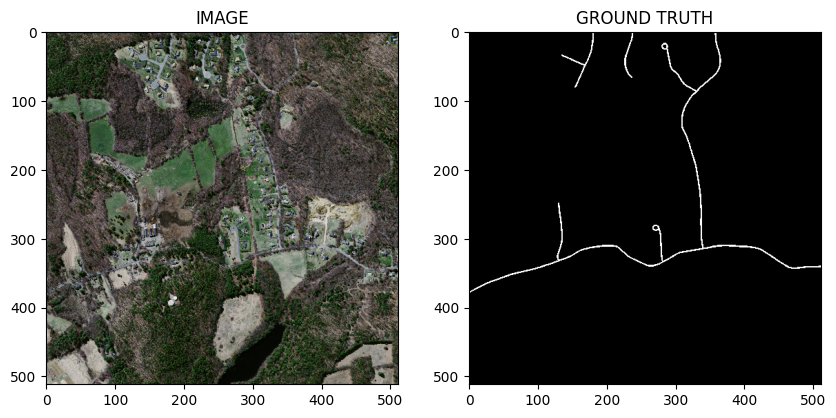

In [31]:
idx=3
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [33]:
#Now import dataloader function
from torch.utils.data import DataLoader

In [34]:
train_loader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=DataLoader(validset,batch_size=BATCH_SIZE)

**Counting Total Number of Batches**

In [35]:
print(f"Total no. of batches in trainloader: {len(train_loader)}")
print(f"Total no. of batches in validloader: {len(valid_loader)}")

Total no. of batches in trainloader: 20
Total no. of batches in validloader: 5


**Now seeing each batch image**

In [37]:
for images,masks in train_loader:
  break

print(f"One batch image shape: {images.shape}")
print(f"One batch mask shape: {masks.shape}")

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [39]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [41]:
class UnetSegmentationModel(nn.Module):
  def __init__(self):
    super(UnetSegmentationModel,self).__init__()

    self.backbone=smp.UnetPlusPlus(
        encoder_name=ENCODER,
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images,masks=None):
    logits=self.backbone(images)
    if masks!=None:
      loss=DiceLoss(mode='binary')(logits,masks)+nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss

    return logits

In [43]:
model=UnetSegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [44]:
def training_function(dataloader,model,optimizer):
  #Activating train mode
  model.train()
  total_loss=0.0
  for images,masks in tqdm(dataloader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(dataloader)

In [45]:
def eval_function(dataloader,model):
  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for images,masks in tqdm(dataloader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)
      logits,loss=model(images,masks)
      total_loss+=loss.item()
    
    return total_loss/len(dataloader)



# Task 8 : Train Model

In [50]:
#Setting up Adam optimizer
optimizer=torch.optim.Adam(params=model.parameters(),lr=LR)
EPOCHS=30

In [52]:
best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss=training_function(train_loader,model,optimizer)
  valid_loss=eval_function(valid_loader,model)

  if valid_loss<best_valid_loss:
    best_valid_loss=valid_loss

    torch.save(model.state_dict(),'best_model.pt')
    print("Model has been saved")

  print(f"Epoch{i+1}/{EPOCHS} training loss: {train_loss} validation_loss: {valid_loss}")


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Model has been saved
Epoch1/30 training loss: 0.5402405008673667 validation_loss: 0.5935782194137573


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch2/30 training loss: 0.5407681986689568 validation_loss: 0.6449425339698791


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch3/30 training loss: 0.5340332597494125 validation_loss: 0.6257379531860352


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch4/30 training loss: 0.5285184040665627 validation_loss: 0.6110803842544555


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Model has been saved
Epoch5/30 training loss: 0.5282734125852585 validation_loss: 0.5892390131950378


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Model has been saved
Epoch6/30 training loss: 0.5151501253247261 validation_loss: 0.5869080424308777


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch7/30 training loss: 0.5208506539463997 validation_loss: 0.6172925233840942


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch8/30 training loss: 0.5097373336553573 validation_loss: 0.5995335936546325


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch9/30 training loss: 0.523743885755539 validation_loss: 0.601052749156952


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch10/30 training loss: 0.5155567735433578 validation_loss: 0.603524112701416


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch11/30 training loss: 0.5215048521757126 validation_loss: 0.6027228116989136


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch12/30 training loss: 0.5052156478166581 validation_loss: 0.606588876247406


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch13/30 training loss: 0.504375059902668 validation_loss: 0.6624976515769958


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch14/30 training loss: 0.501094289124012 validation_loss: 0.633939242362976


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch15/30 training loss: 0.5048111379146576 validation_loss: 0.5869382381439209


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch16/30 training loss: 0.5088598817586899 validation_loss: 0.5986554741859436


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Model has been saved
Epoch17/30 training loss: 0.5024134948849678 validation_loss: 0.5791288375854492


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch18/30 training loss: 0.5053931131958962 validation_loss: 0.6214915633201599


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Model has been saved
Epoch19/30 training loss: 0.5013621553778649 validation_loss: 0.5758830070495605


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch20/30 training loss: 0.49539184719324114 validation_loss: 0.5940146327018738


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch21/30 training loss: 0.4990225940942764 validation_loss: 0.5905382633209229


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Model has been saved
Epoch22/30 training loss: 0.498178930580616 validation_loss: 0.571094274520874


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch23/30 training loss: 0.4959013268351555 validation_loss: 0.5800402402877808


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch24/30 training loss: 0.4873198181390762 validation_loss: 0.57699054479599


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch25/30 training loss: 0.48685851097106936 validation_loss: 0.6064955353736877


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch26/30 training loss: 0.4904226988554001 validation_loss: 0.6067533612251281


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch27/30 training loss: 0.4818827539682388 validation_loss: 0.6024443984031678


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Model has been saved
Epoch28/30 training loss: 0.479095496237278 validation_loss: 0.5692883253097534


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch29/30 training loss: 0.47988074719905854 validation_loss: 0.5927125930786132


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

Epoch30/30 training loss: 0.47194749265909197 validation_loss: 0.6321277499198914


# Task 9 : Inference

In [53]:
idx=17
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask=validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

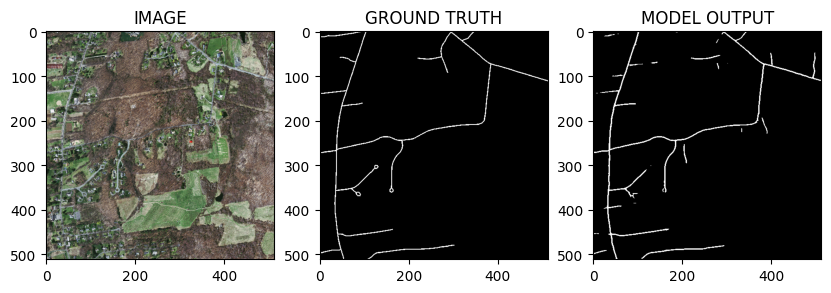

In [54]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

